# Patches with Simulation Data

#### Description

The aim here is to apply Patches to the simulated data (here: t100,s80,b0) in its interpretability mode to get interpretable scores. These scores will then be compared to the gene ground truths (i.e., is a gene a type or state gene, or both) and to the typeness and stateness scores from the FSS paper.

Given gene expression profiles and condition labels, Patches produces two latent representations of each cell, a common representation (similar across all conditions) and a condition-specific representation (similar inside of each condition). From these representations, a linear decoder can reconstruct gene expression profiles while providing interpretable attribute scores and a common score for each gene via  its weights. Importantly, one common score is returned as the sum of the weights corresponding to the dimensions of the common latent representation, and one attribute score is returned for each attribute of all conditions as the sum of the weights corresponding to the dimensions of each attribute in the condition-specific latent representation.

Due to that, a cell type score can only be obtained if the cell types are input as condition to the model, i.e., they must be know (or obtained by clustering + marker gene analysis). A single cell type or state score could potentially be obtained by combining the attribute scores of all type or state attributes (e.g., sum of absolutes or sum of squares), respectively. The common score might contain cell type information if the cell type is not given as condition to the model, but this is to be explored.

Thus, Patches is run with both only state as condition and type + state as conditions, and the scores are further explored as described above. The workflow is adapted from this tutorial: https://ladder.readthedocs.io/en/latest/notebooks/interpretable_vu_tutorial.html


#### Possible tuning points:

- data preparation:
    - run with all genes or run with of HVGs (get scores for all genes vs. better performance with top 1500 genes)
    - batch effect correction

- `workflow.prep_model`:
    - ~~run with or without `batch_key` (here: `batch_key = sample_id`)~~ *does not make noticable difference and makes sense to do batch correction*
    - ~~use `cell_type_label_key = cluster_id` (clusters correspond to cell type in simulation)~~ *only used for subsetting evaluation for a cell type*
    - use different `minibatch_size` (default is 128, maybe try smaller size with ~2000 cells)
    - ~~tune `model_args` and `optim_args`~~ *maybe consider lr otherwise not necessary*

- `workflow.run_model`:
    - run with different number of `max_epochs` (default is 1500)
    - try different `convergence_threshold` and `convergence_window`

## Import Packages

In [1]:
import scanpy as sc
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from ladder.scripts import InterpretableWorkflow
from umap import UMAP

## Helper Functions

In [2]:
def force_aspect(ax, aspect=1):
    """
    Force aspect ratio of a matplotlib axis to be equal. Helper function for plotting.
    Taken from Patches tutorial docs.

    Parameters
    ----------
    ax : matplotlib axis
        The axis to set the aspect ratio for.
    aspect : float, optional
        The aspect ratio to set. Default is 1 (equal).
    """
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

def create_umap_df(workflow, model):
    """
    Create a dataframe with UMAP and PCA reductions for plotting.
    Adapted from Patches tutorial docs.

    Parameters
    ----------
    workflow : InterpretableWorkflow
        The fitted InterpretableWorkflow object.
    model : str
        The model type, either "Patches" or "Base".
    
    Returns
    -------
    pd.DataFrame
        A dataframe with UMAP and PCA reductions for plotting.
    """
    # UMAP reducers
    reducer_base = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)
    reducer = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)

    match model:
        case "Patches":
            # all data reductions needed for the plots
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X))
            z_umap = reducer.fit_transform(workflow.anndata.obsm['patches_z_latent']) # Z
            w_umap = reducer.fit_transform(workflow.anndata.obsm['patches_w_latent']) # W
            
            w_pca = sc.pp.pca(workflow.anndata.obsm['patches_w_latent'], random_state=42)[:,:2] # W PCA, grab first 2 PCs
            z_pca = sc.pp.pca(workflow.anndata.obsm['patches_z_latent'], random_state=42)[:,:2] # Z PCA, grab first 2 PCs

            # create dataframe and add all reductions
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["w_umap_1"], df["w_umap_2"] = w_umap[:,0], w_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
            df["w_pc_1"], df["w_pc_2"] = w_pca[:,0], w_pca[:,1]

        case "Base":
            anndata = workflow.anndata.copy()
            anndata.X = anndata.layers["counts"]
            
            sc.pp.normalize_total(anndata, target_sum=1e4)
            sc.pp.log1p(anndata)
            sc.tl.pca(anndata, svd_solver="arpack")
            
            base_umap = reducer_base.fit_transform(np.array(anndata.X))
            base_pca = anndata.obsm['X_pca'][:,:2]

            df = pd.DataFrame(base_umap)
            df.index = anndata.obs.index

            df.columns = ["base_umap_1", "base_umap_2"]
            df["base_pc_1"], df["base_pc_2"] = base_pca[:,0], base_pca[:,1]

    # add metadata
    df["group_id"], df["cluster_id"], df["sample_id"] = workflow.anndata.obs["group_id"], workflow.anndata.obs["cluster_id"], workflow.anndata.obs["sample_id"]

    return df

## Load and Prepare Data

In [3]:
# load data
adata = sc.read_h5ad("../../data/sim/01-pro/t100,s80,b0.h5ad")

# highly variable gene selection on log-normalized data (optional)
# adata.X = adata.layers["logcounts"]
# sc.pp.highly_variable_genes(adata, n_top_genes=1500)
# sc.pl.highly_variable_genes(adata)
# adata = adata[:, adata.var["highly_variable"]].copy()

# reset to raw counts for model input (as stated in docs)
adata.X = adata.layers["counts"]
adata

AnnData object with n_obs × n_vars = 2412 × 1979
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.GeneMean._', 's

## Run Patches in Interpretable Workflow - Condition (State) Only

In [4]:
# initialize workflow object
workflow = InterpretableWorkflow(adata.copy(), verbose=True, random_seed=42)

# define the condition classes & batch key to prepare the data
factors = ["group_id"]
workflow.prep_model(factors, batch_key="sample_id", minibatch_size=32, model_type='Patches', model_args={'ld_normalize' : True})

# run model
workflow.run_model(max_epochs=1500, convergence_threshold=1e-5, convergence_window=50)
workflow.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_con")

Initialized workflow to run interpretable model.

Condition classes : ['group_id']
Number of attributes per class : [2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 1.579080343607883e-05, 'num_labels': 2, 'len_attrs': [2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.001, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 1500, with convergence eps 1e-05.
Using device: cpu

Epoch : 0 || Train Loss: 205.60707 // 0.78978 || Test Loss: 116.48741 // 1.51792 || Warmup : False
Epoch : 1 || Train Loss: 102.16454 // 0.85153 || Test Loss: 59.90899 // 0.98527 || Warmup : False
Epoch : 2 || Train Loss: 20.22318 // 0.43892 || Test Loss: 10.68564 // 0.18699 || Warmup : False
Epoch : 3 || Train Loss: 9.4834 // 0.18436 || Test Loss: 8.8959 // 0.22091 || Warmup : Fa

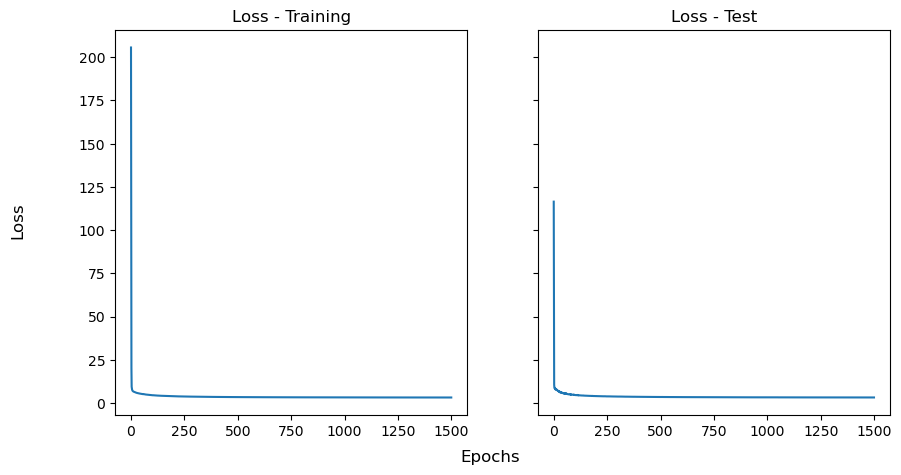

In [5]:
workflow.plot_loss()

In [6]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [7]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 211.82it/s]

Results
RMSE : 4.676 +- 0.032
Profile Correlation : 0.774 +- 0.006
2-Sliced Wasserstein : 45.761 +- 0.248
Chamfer Discrepancy : 16944.069 +- 87.998


{'RMSE': [np.float64(4.676), np.float64(0.032)],
 'Profile Correlation': [np.float64(0.774), np.float64(0.006)],
 '2-Sliced Wasserstein': [np.float64(45.761), np.float64(0.248)],
 'Chamfer Discrepancy': [np.float64(16944.069), np.float64(87.998)]}

In [8]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,sample_1.Group1.Gene._,sample_1.Group1.GeneMean._,sample_2.Group1.Gene._,sample_2.Group1.GeneMean._,sample_3.Group1.Gene._,sample_3.Group1.GeneMean._,sample_4.Group1.Gene._,sample_4.Group1.GeneMean._,sample_5.Group1.Gene._,sample_5.Group1.GeneMean._,...,GroupDE.Group3,ConditionDE.Condition2,ConditionDE.Condition1,meanQuantileNorm,cvQuantileNorm,gene_id,bio,Condition1_score_Patches,Condition2_score_Patches,common_score_Patches
gene0001,gene_0001,0.348913,gene_0001,0.339048,gene_0001,0.355008,gene_0001,0.376501,gene_0001,0.318932,...,1.000000,1.000000,1.000000,0.349444,0.055493,gene0001,0.000427,0.181529,-0.020391,0.077584
gene0002,gene_0002,0.233752,gene_0002,0.266857,gene_0002,0.090465,gene_0002,0.084239,gene_0002,0.262775,...,1.000000,2.689837,1.000000,0.090716,0.069999,gene0002,0.025194,0.379996,-0.279606,-0.658717
gene0003,gene_0003,1.054020,gene_0003,1.055463,gene_0003,1.050622,gene_0003,1.220659,gene_0003,1.215103,...,1.000000,1.000000,1.000000,1.053979,0.005916,gene0003,0.012466,0.279858,-0.272557,-0.121718
gene0004,gene_0004,1.333374,gene_0004,1.354434,gene_0004,3.302799,gene_0004,3.356972,gene_0004,1.311693,...,0.405406,1.000000,2.402111,1.348729,0.024612,gene0004,-0.105671,-0.248503,-0.169702,0.517649
gene0005,gene_0005,0.359099,gene_0005,0.359099,gene_0005,0.336419,gene_0005,0.365225,gene_0005,0.338109,...,1.000000,1.000000,1.000000,0.346796,0.048252,gene0005,-0.014074,0.140248,0.209891,-0.336876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene1996,gene_1996,5.450085,gene_1996,5.842951,gene_1996,2.373400,gene_1996,2.211219,gene_1996,5.734554,...,1.000000,2.386650,1.000000,2.356634,0.028423,gene1996,-0.014956,0.095702,-0.082802,0.215813
gene1997,gene_1997,3.712653,gene_1997,4.112237,gene_1997,4.176653,gene_1997,4.402447,gene_1997,4.342350,...,1.000000,1.000000,1.000000,4.132944,0.059477,gene1997,-0.511830,-0.074474,-0.025799,0.335086
gene1998,gene_1998,3.358019,gene_1998,2.716563,gene_1998,3.271921,gene_1998,3.314637,gene_1998,3.261122,...,1.000000,1.000000,1.000000,3.208973,0.076022,gene1998,-0.395457,0.071872,-0.034750,0.324938
gene1999,gene_1999,1.414115,gene_1999,1.194894,gene_1999,1.214520,gene_1999,1.187953,gene_1999,1.102327,...,1.000000,1.000000,1.000000,1.175527,0.033697,gene1999,-0.107000,-0.285930,-0.007733,0.081446


In [9]:
for gene in (workflow.anndata.var["Condition2_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene, workflow.anndata.var.loc[gene, ["Condition2_score_Patches"]].values[0])

gene0862 0.48865578473211957
gene1952 0.4166284916747694
gene1455 0.4125498232384961
gene1219 0.4110796919437171
gene0568 0.4064360170200428
gene0879 0.3984787816380262
gene0584 0.3912513762342058
gene1953 0.39003668286268633
gene0808 0.38109654945834404
gene0101 0.3809101091856942
gene0359 0.37945924069245257
gene1330 0.376875579642289
gene1035 0.37322513157618453
gene1762 0.37160256084844023
gene0993 0.3712723816232599
gene1710 0.36568847203141025
gene1764 0.36534546107190724
gene1966 0.36501237689121113
gene1146 0.36345068545410564
gene0875 0.3632580354849734
gene1046 0.3630669265622955
gene1304 0.36201776468704244
gene1933 0.36129927767246495
gene1755 0.360154298703968
gene1748 0.35603884192772095
gene0119 0.3553597711689313
gene1798 0.35358659284018246
gene0448 0.35337568189363766
gene0569 0.34903008217328335
gene0819 0.3489364607054679
gene1857 0.34879699459619123
gene1152 0.34818203494471034
gene0697 0.3468105419196894
gene0102 0.3461118467569887
gene1408 0.34334800704903273
gen

In [10]:
workflow.anndata.var.loc[:, ["Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_con_loadings.csv"
)

In [11]:
df_patches = create_umap_df(workflow, "Patches")
df_patches

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_1,base_2,z_umap_1,z_umap_2,w_umap_1,w_umap_2,z_pc_1,z_pc_2,w_pc_1,w_pc_2,group_id,cluster_id,sample_id
cell0001,5.424466,16.515356,-3.671395,-2.812567,9.380106,2.607300,-0.114911,0.039249,1.381062,-0.011089,Condition2,Group1,sample_1
cell0002,4.792794,18.425442,-3.438585,-4.063869,8.294728,-0.808882,-0.126847,0.048709,1.380052,-0.014842,Condition2,Group1,sample_1
cell0003,6.116129,16.298819,10.805477,6.263369,17.662544,-1.497277,0.041120,0.004359,1.386200,0.007251,Condition2,Group1,sample_1
cell0004,4.174799,12.824737,-4.489678,0.672124,9.407168,2.786490,-0.089403,0.022876,1.380308,-0.010963,Condition2,Group1,sample_1
cell0005,6.206625,14.838022,14.726842,1.952661,16.771311,-1.427404,0.059786,0.024125,1.387715,0.006277,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell2408,8.382854,15.395600,10.758488,15.026582,-0.334878,4.904697,0.014729,-0.019194,-1.382402,-0.002887,Condition1,Group3,sample_6
cell2409,4.864100,12.387937,15.406272,5.083404,-3.527098,7.241823,0.050369,0.008993,-1.384251,0.005744,Condition1,Group3,sample_6
cell2410,8.861316,15.259934,14.814981,1.915604,-1.053506,6.641663,0.058406,0.021213,-1.385524,0.004928,Condition1,Group3,sample_6
cell2411,4.765234,12.471651,10.022017,15.734774,0.450160,5.745069,0.009886,-0.019487,-1.382746,-0.002295,Condition1,Group3,sample_6


In [12]:
df_base = create_umap_df(workflow, "Base")
df_base

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_umap_1,base_umap_2,base_pc_1,base_pc_2,group_id,cluster_id,sample_id
cell0001,13.139887,-9.605938,-4.849263,-3.316357,Condition2,Group1,sample_1
cell0002,12.751695,-9.777439,-4.765915,-7.685525,Condition2,Group1,sample_1
cell0003,12.639292,-9.451825,-5.106972,-2.331140,Condition2,Group1,sample_1
cell0004,12.769624,-9.652902,-4.646341,-4.950750,Condition2,Group1,sample_1
cell0005,12.384638,-9.934749,-2.878461,-3.809063,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...
cell2408,9.684843,-7.916964,5.434552,-3.218596,Condition1,Group3,sample_6
cell2409,10.074035,-6.965591,4.599032,1.302506,Condition1,Group3,sample_6
cell2410,9.592915,-7.213837,3.790695,1.169275,Condition1,Group3,sample_6
cell2411,9.808216,-7.745580,3.241766,0.303070,Condition1,Group3,sample_6


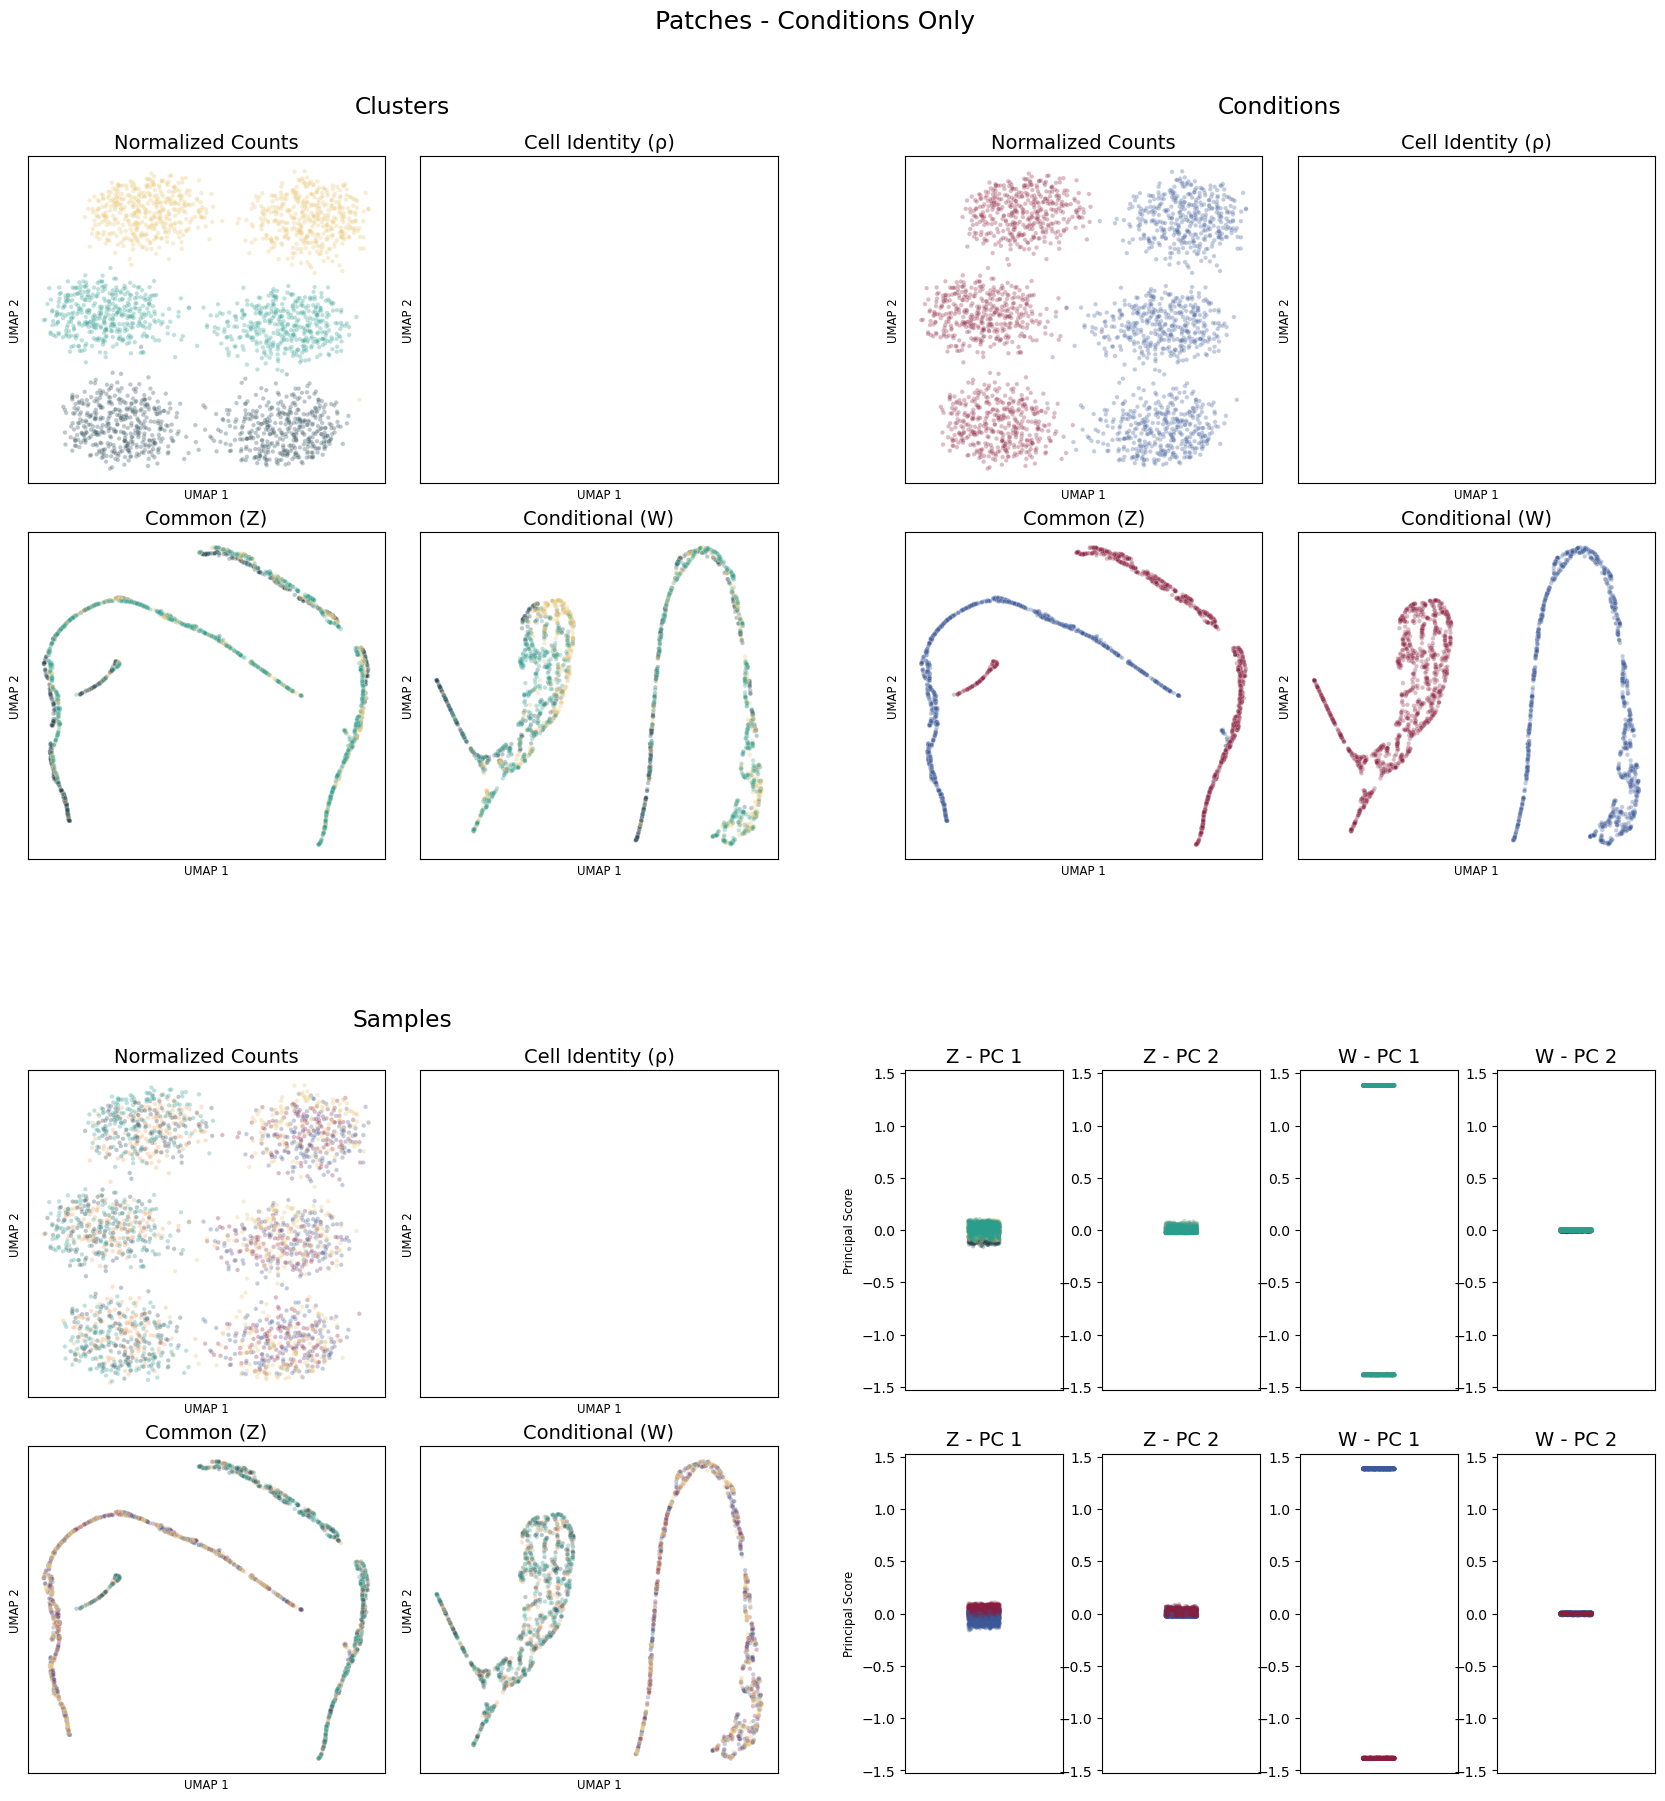

In [13]:
# Figure skeleton (adapted from Patches tutorial docs)


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)


## save and show figure
fig.suptitle("Patches - Conditions Only", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_con.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
workflow.anndata

AnnData object with n_obs × n_vars = 2412 × 1979
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo', 'factorized'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.G

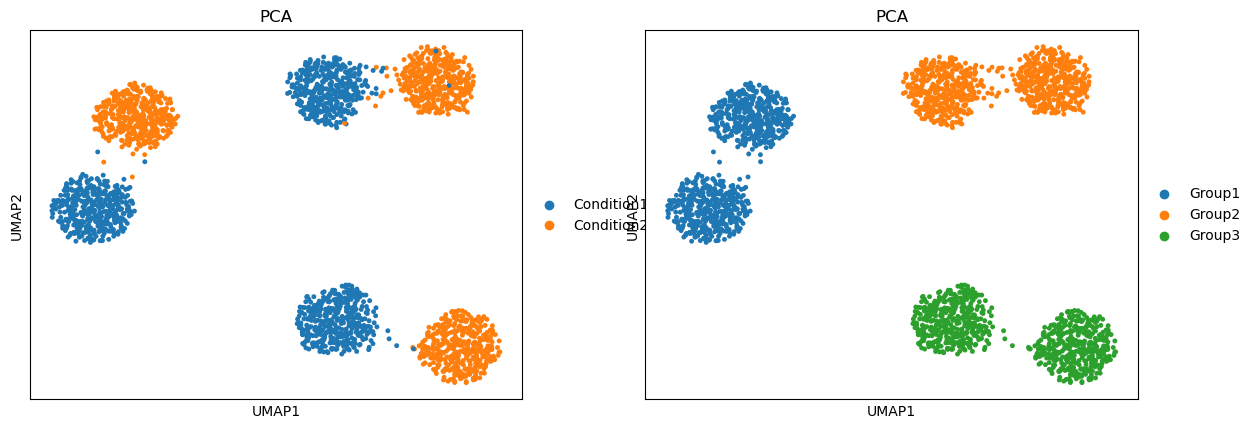

In [15]:
sc.pp.neighbors(workflow.anndata, use_rep="PCA")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["PCA", "PCA"])

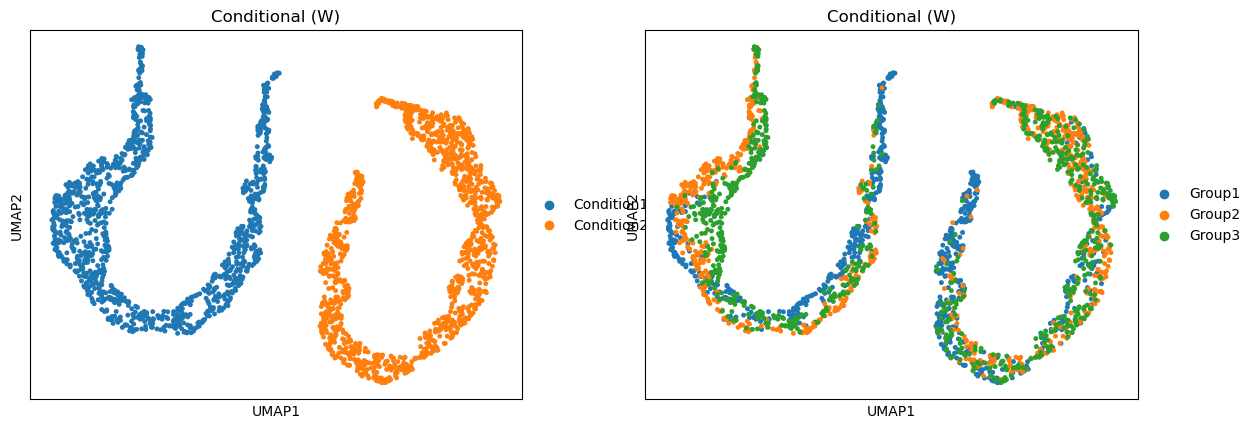

In [16]:
sc.pp.neighbors(workflow.anndata, use_rep="patches_w_latent")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Conditional (W)", "Conditional (W)"])

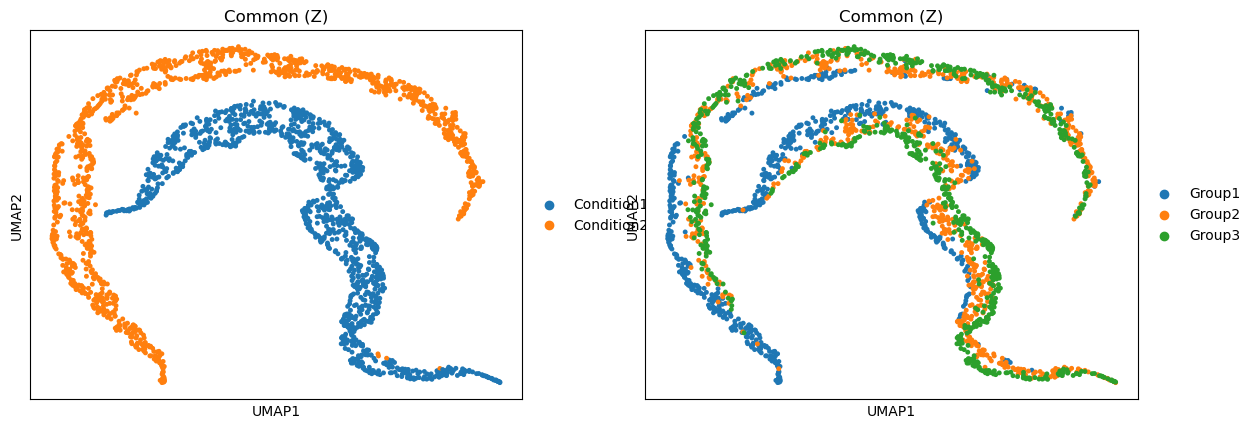

In [17]:
sc.pp.neighbors(workflow.anndata, use_rep="patches_z_latent")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Common (Z)", "Common (Z)"])

## Run Patches in Interpretable Workflow - Condition + Cluster (State + Type)

In [18]:
# initialize workflow object
workflow2 = InterpretableWorkflow(adata.copy(), verbose=True, random_seed=42)

# define the condition classes & batch key to prepare the data
factors = ["group_id", "cluster_id"]
workflow2.prep_model(factors, batch_key="sample_id", minibatch_size=32, model_type='Patches', model_args={'ld_normalize' : True})

# run model
workflow2.run_model(max_epochs=1500, convergence_threshold=1e-5, convergence_window=50)
workflow2.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con")

Initialized workflow to run interpretable model.

Condition classes : ['group_id', 'cluster_id']
Number of attributes per class : [2, 3]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 1.579080343607883e-05, 'num_labels': 5, 'len_attrs': [2, 3]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.001, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 1500, with convergence eps 1e-05.
Using device: cpu

Epoch : 0 || Train Loss: 203.6218 // 1.84887 || Test Loss: 136.12819 // 1.6606 || Warmup : False
Epoch : 1 || Train Loss: 105.42081 // 1.94057 || Test Loss: 65.61684 // 2.04572 || Warmup : False
Epoch : 2 || Train Loss: 19.87106 // 1.58356 || Test Loss: 10.09992 // 1.1103 || Warmup : False
Epoch : 3 || Train Loss: 8.95819 // 1.00209 || Test Loss: 8.37926 // 1.0

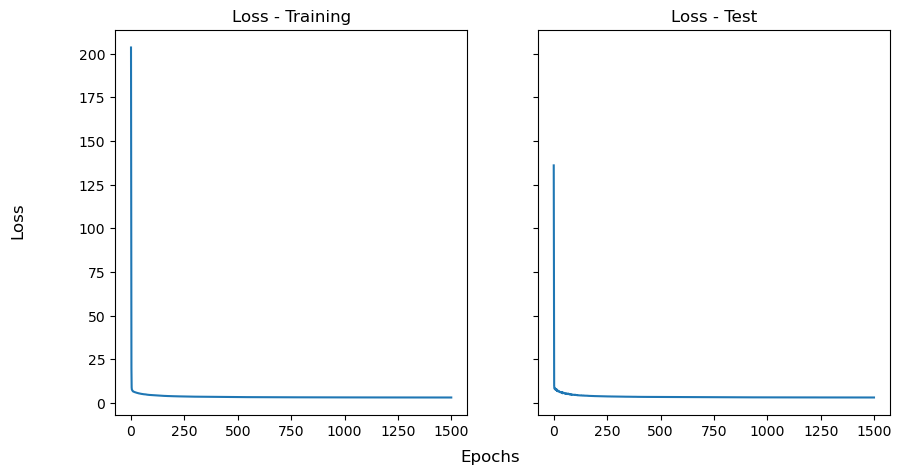

In [19]:
workflow2.plot_loss()

In [20]:
workflow2.write_embeddings()
workflow2.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [21]:
workflow2.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 200.50it/s]

Results
RMSE : 6.327 +- 0.012
Profile Correlation : 0.48 +- 0.005
2-Sliced Wasserstein : 48.731 +- 0.504
Chamfer Discrepancy : 18642.31 +- 436.132


{'RMSE': [np.float64(6.327), np.float64(0.012)],
 'Profile Correlation': [np.float64(0.48), np.float64(0.005)],
 '2-Sliced Wasserstein': [np.float64(48.731), np.float64(0.504)],
 'Chamfer Discrepancy': [np.float64(18642.31), np.float64(436.132)]}

In [22]:
workflow2.get_conditional_loadings()
workflow2.get_common_loadings()
workflow2.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,sample_1.Group1.Gene._,sample_1.Group1.GeneMean._,sample_2.Group1.Gene._,sample_2.Group1.GeneMean._,sample_3.Group1.Gene._,sample_3.Group1.GeneMean._,sample_4.Group1.Gene._,sample_4.Group1.GeneMean._,sample_5.Group1.Gene._,sample_5.Group1.GeneMean._,...,meanQuantileNorm,cvQuantileNorm,gene_id,bio,Condition1_score_Patches,Condition2_score_Patches,Group1_score_Patches,Group2_score_Patches,Group3_score_Patches,common_score_Patches
gene0001,gene_0001,0.348913,gene_0001,0.339048,gene_0001,0.355008,gene_0001,0.376501,gene_0001,0.318932,...,0.349444,0.055493,gene0001,0.000427,-0.232724,0.343711,-0.042194,0.206230,-0.035248,0.039186
gene0002,gene_0002,0.233752,gene_0002,0.266857,gene_0002,0.090465,gene_0002,0.084239,gene_0002,0.262775,...,0.090716,0.069999,gene0002,0.025194,-0.392418,-0.003177,0.173372,0.031214,0.088787,0.392393
gene0003,gene_0003,1.054020,gene_0003,1.055463,gene_0003,1.050622,gene_0003,1.220659,gene_0003,1.215103,...,1.053979,0.005916,gene0003,0.012466,-0.035615,0.078433,-0.039881,0.065441,0.203664,-0.158180
gene0004,gene_0004,1.333374,gene_0004,1.354434,gene_0004,3.302799,gene_0004,3.356972,gene_0004,1.311693,...,1.348729,0.024612,gene0004,-0.105671,0.242640,0.164232,-0.028808,-0.111956,0.449991,-0.281758
gene0005,gene_0005,0.359099,gene_0005,0.359099,gene_0005,0.336419,gene_0005,0.365225,gene_0005,0.338109,...,0.346796,0.048252,gene0005,-0.014074,-0.147126,0.228918,0.187385,0.120148,0.072605,0.261308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene1996,gene_1996,5.450085,gene_1996,5.842951,gene_1996,2.373400,gene_1996,2.211219,gene_1996,5.734554,...,2.356634,0.028423,gene1996,-0.014956,-0.158580,-0.316664,-0.211556,-0.178962,-0.058160,-0.150071
gene1997,gene_1997,3.712653,gene_1997,4.112237,gene_1997,4.176653,gene_1997,4.402447,gene_1997,4.342350,...,4.132944,0.059477,gene1997,-0.511830,0.192860,-0.258438,-0.060639,-0.202534,-0.211112,-0.081328
gene1998,gene_1998,3.358019,gene_1998,2.716563,gene_1998,3.271921,gene_1998,3.314637,gene_1998,3.261122,...,3.208973,0.076022,gene1998,-0.395457,0.074166,-0.150189,-0.138890,0.004062,0.016956,-0.282878
gene1999,gene_1999,1.414115,gene_1999,1.194894,gene_1999,1.214520,gene_1999,1.187953,gene_1999,1.102327,...,1.175527,0.033697,gene1999,-0.107000,-0.084574,0.134177,0.098004,0.081700,-0.011603,-0.330276


In [23]:
for gene in (workflow2.anndata.var["Condition2_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene, workflow2.anndata.var.loc[gene, ["Condition2_score_Patches"]].values[0])

gene1945 0.7264770167318431
gene1122 0.6999027389514625
gene0597 0.6969531672966588
gene0714 0.6817273311054003
gene1082 0.6666502537924183
gene1635 0.6478044286688595
gene1110 0.6469322067415076
gene1956 0.6365565492065652
gene0478 0.6338692726642456
gene1438 0.6315308431601008
gene1432 0.6283097631470778
gene0692 0.6247049127344398
gene0598 0.6194338713187011
gene1187 0.6097144484481016
gene0887 0.6088169457801387
gene0995 0.6034078707147547
gene1372 0.601055193286931
gene1971 0.5990338160198401
gene0877 0.5965492999579262
gene1026 0.5949013916548613
gene2000 0.592763632084923
gene1206 0.5906662649709815
gene0043 0.590400073288707
gene0868 0.5903836538720595
gene0603 0.5833555713631389
gene1464 0.5809312478395837
gene0155 0.5753400631555943
gene1471 0.5750582376125822
gene1476 0.573150402481591
gene1129 0.5724366568348687
gene1031 0.5644728877817549
gene0378 0.5643382489730944
gene1233 0.5627393249041261
gene0523 0.5609494507658855
gene1241 0.5591514328118079
gene0219 0.5580487447023

In [24]:
workflow2.anndata.var.loc[:, [
    "Condition1_score_Patches", 
    "Condition2_score_Patches", 
    "common_score_Patches", 
    "Group1_score_Patches", 
    "Group2_score_Patches", 
    "Group3_score_Patches"
    ]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con_loadings.csv"
)

In [25]:
df_patches = create_umap_df(workflow2, "Patches")
df_patches

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_1,base_2,z_umap_1,z_umap_2,w_umap_1,w_umap_2,z_pc_1,z_pc_2,w_pc_1,w_pc_2,group_id,cluster_id,sample_id
cell0001,5.424466,16.515356,0.378963,-1.700404,14.678359,3.559476,0.000989,-0.007990,-1.909190,0.545190,Condition2,Group1,sample_1
cell0002,4.792794,18.425442,-1.473137,-1.574567,15.416967,2.445536,0.012294,-0.008748,-1.908236,0.544898,Condition2,Group1,sample_1
cell0003,6.116129,16.298819,2.274771,-1.594463,12.841380,4.990860,-0.014326,-0.015124,-1.911063,0.546952,Condition2,Group1,sample_1
cell0004,4.174799,12.824737,-0.271216,-0.758460,14.317369,3.868539,0.005042,-0.010283,-1.909350,0.544796,Condition2,Group1,sample_1
cell0005,6.206625,14.838022,10.112255,0.892569,12.451610,5.010567,-0.051404,-0.011174,-1.912631,0.547122,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell2408,8.382854,15.395600,9.771414,7.062946,-4.215665,-11.090860,0.000888,-0.001027,1.896622,0.672166,Condition1,Group3,sample_6
cell2409,4.864100,12.387937,9.635160,9.162085,-2.654383,-11.806643,0.015162,0.005891,1.897003,0.671733,Condition1,Group3,sample_6
cell2410,8.861316,15.259934,9.887572,7.119017,-2.180038,-10.652053,0.002952,-0.000987,1.896676,0.671791,Condition1,Group3,sample_6
cell2411,4.765234,12.471651,8.963145,9.607028,-3.396400,-12.339517,0.019294,0.002617,1.898090,0.671551,Condition1,Group3,sample_6


In [26]:
df_base = create_umap_df(workflow2, "Base")
df_base

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_umap_1,base_umap_2,base_pc_1,base_pc_2,group_id,cluster_id,sample_id
cell0001,13.139887,-9.605938,-4.849263,-3.316357,Condition2,Group1,sample_1
cell0002,12.751695,-9.777439,-4.765915,-7.685525,Condition2,Group1,sample_1
cell0003,12.639292,-9.451825,-5.106972,-2.331140,Condition2,Group1,sample_1
cell0004,12.769624,-9.652902,-4.646341,-4.950750,Condition2,Group1,sample_1
cell0005,12.384638,-9.934749,-2.878461,-3.809063,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...
cell2408,9.684843,-7.916964,5.434552,-3.218596,Condition1,Group3,sample_6
cell2409,10.074035,-6.965591,4.599032,1.302506,Condition1,Group3,sample_6
cell2410,9.592915,-7.213837,3.790695,1.169275,Condition1,Group3,sample_6
cell2411,9.808216,-7.745580,3.241766,0.303070,Condition1,Group3,sample_6


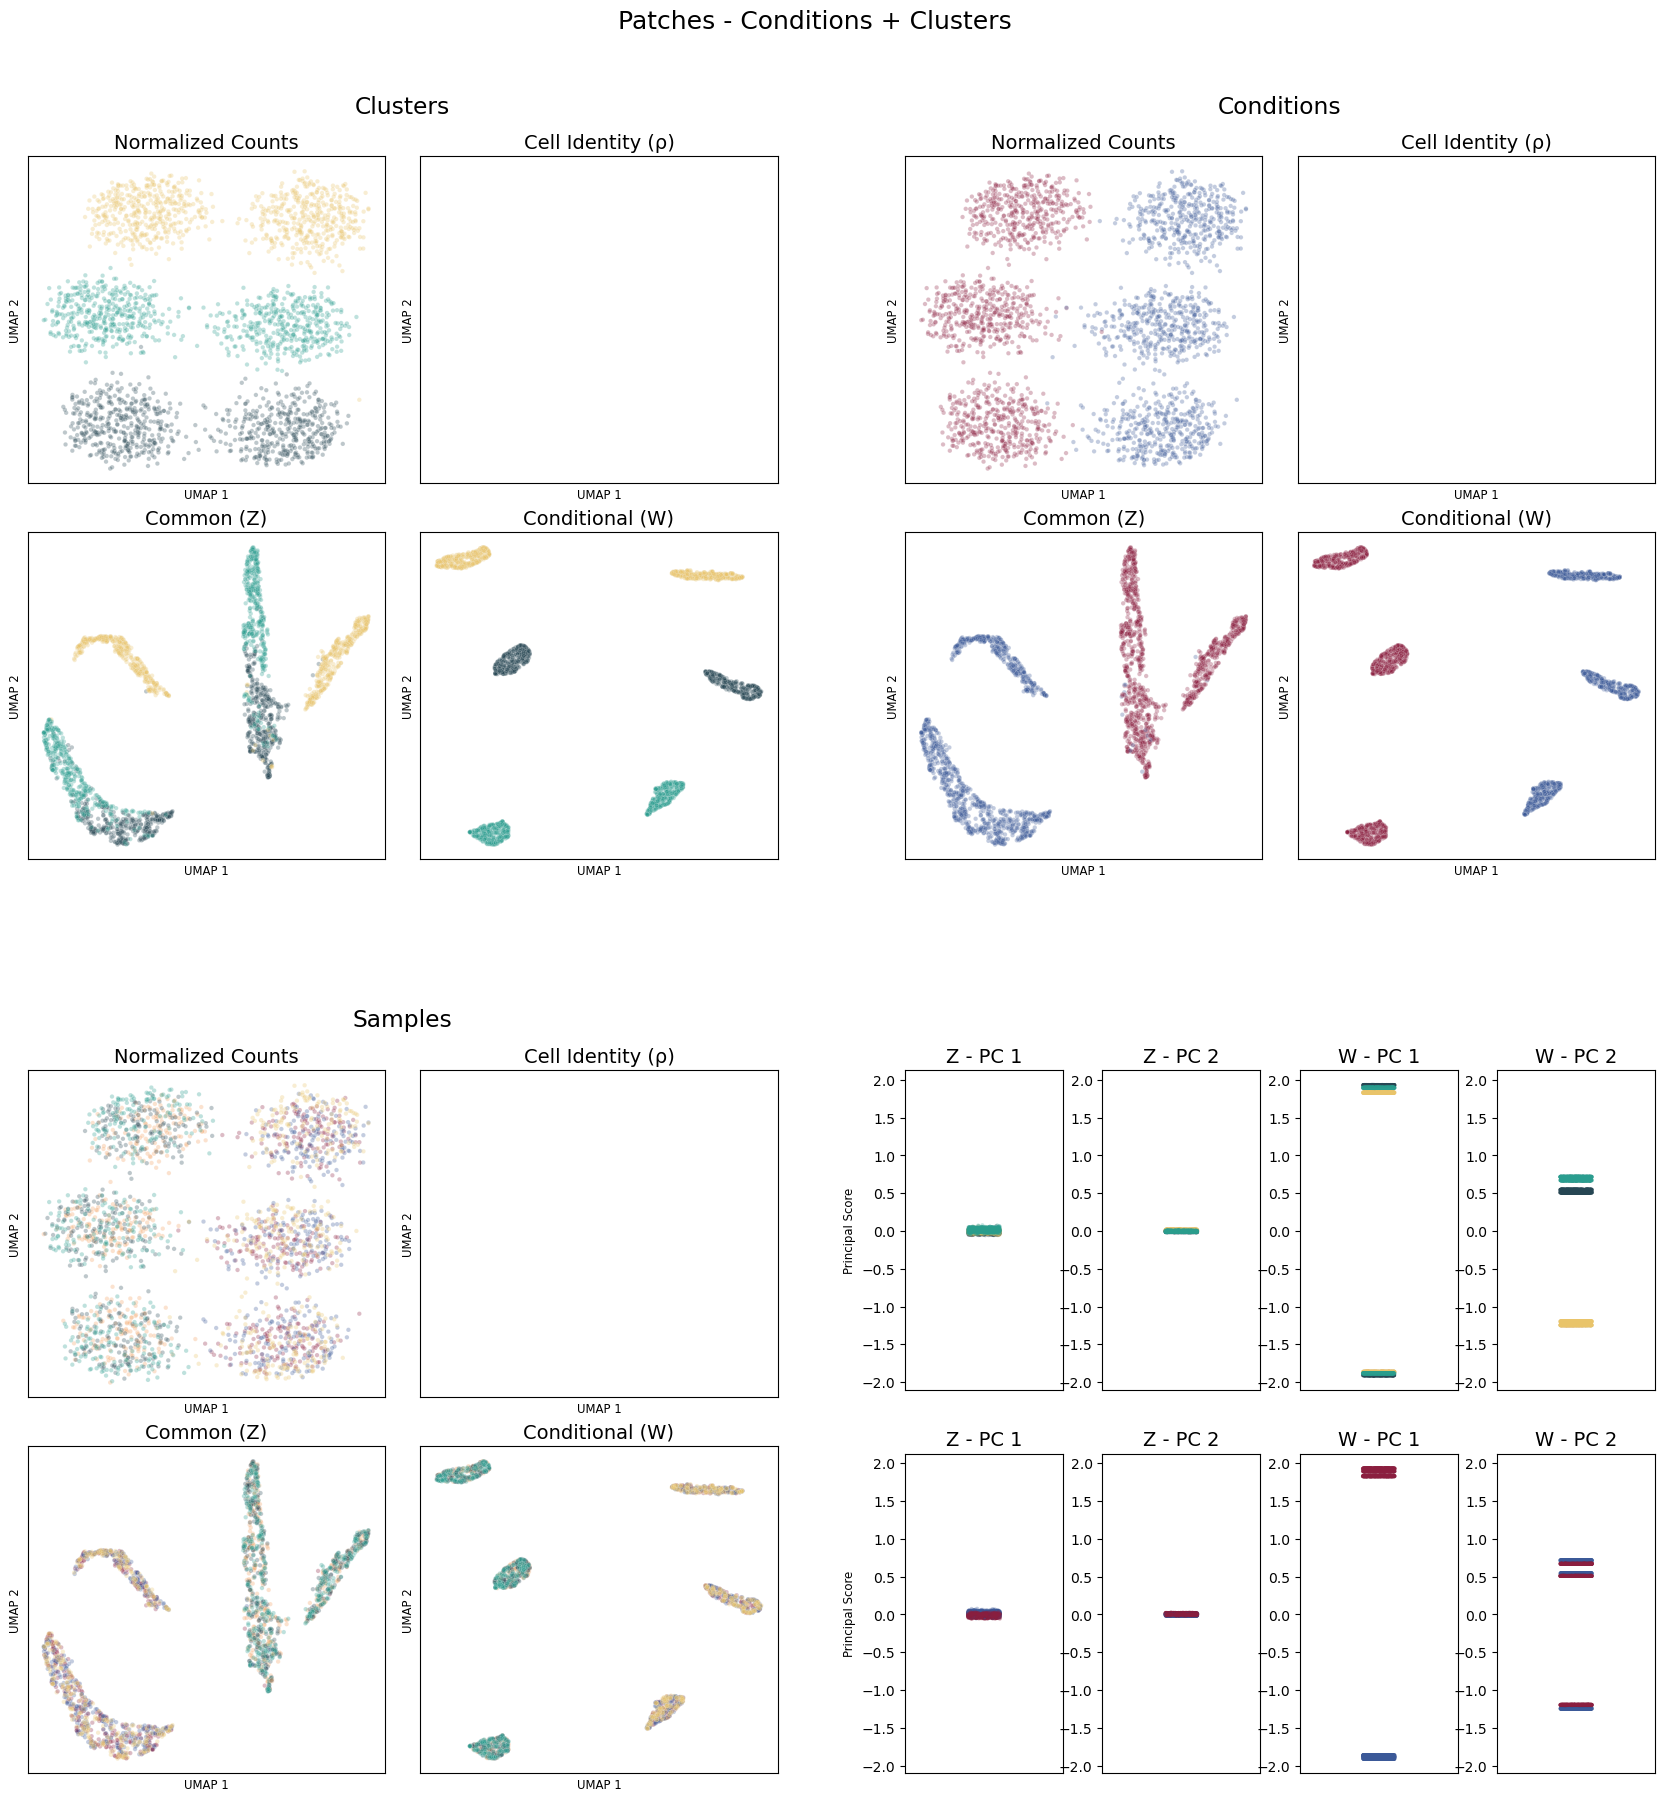

In [27]:
# Figure skeleton (adapted from Patches tutorial docs)


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)


## save and show figure
fig.suptitle("Patches - Conditions + Clusters", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_clu_con.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
workflow2.anndata

AnnData object with n_obs × n_vars = 2412 × 1979
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo', 'factorized'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.G

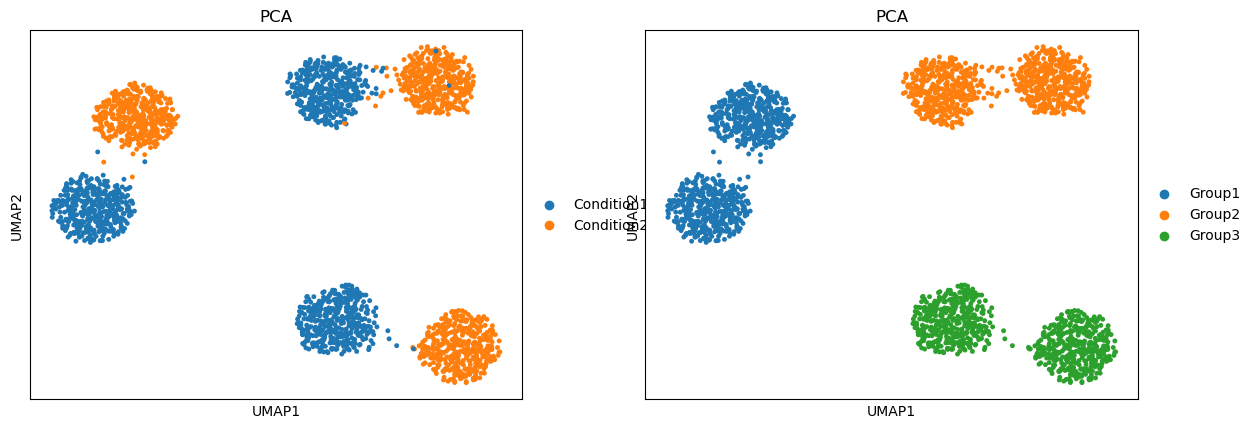

In [29]:
sc.pp.neighbors(workflow2.anndata, use_rep="PCA")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["PCA", "PCA"])

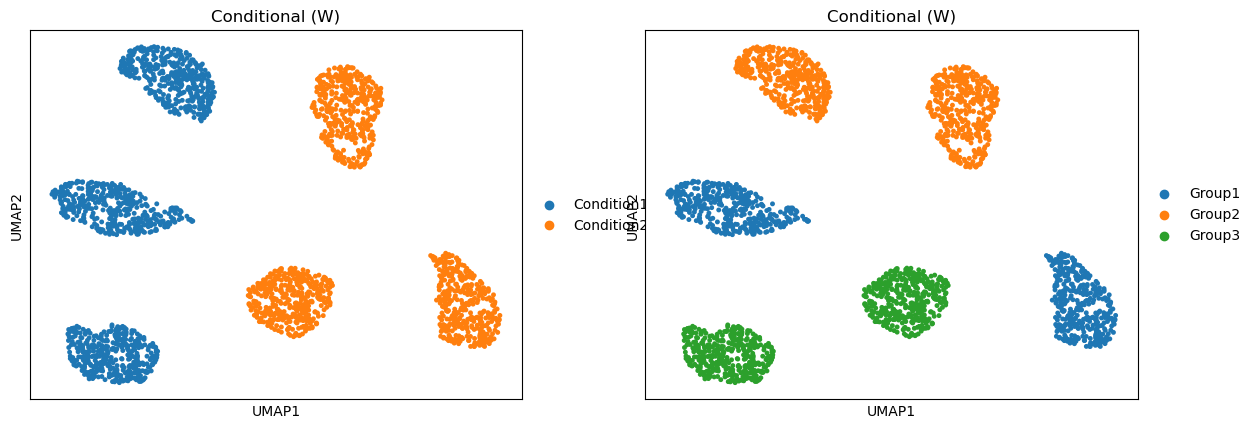

In [30]:
sc.pp.neighbors(workflow2.anndata, use_rep="patches_w_latent")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["Conditional (W)", "Conditional (W)"])

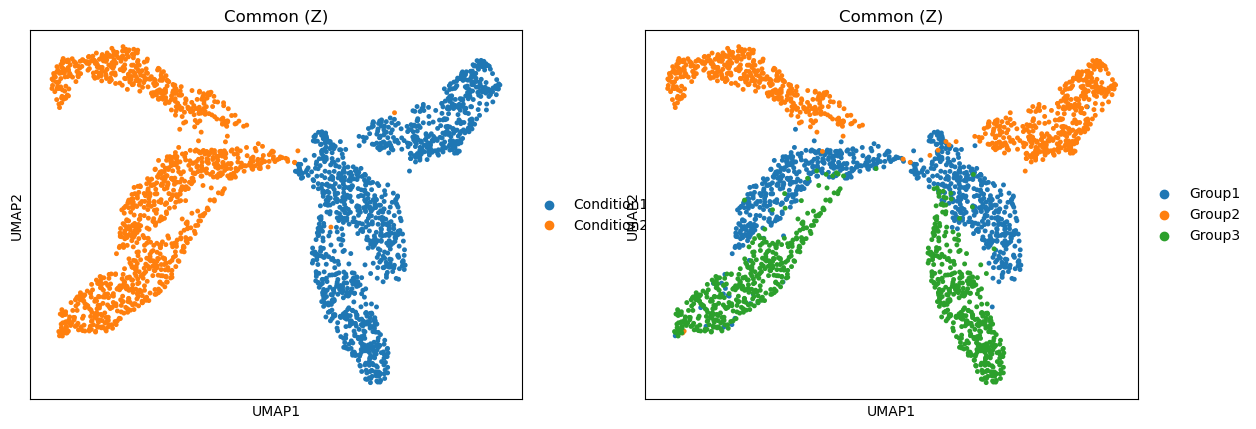

In [31]:
sc.pp.neighbors(workflow2.anndata, use_rep="patches_z_latent")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["Common (Z)", "Common (Z)"])